In [1]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt 

from scipy.stats import linregress

lib = ctypes.CDLL("../lib.so")

In [2]:
atypes = [
    np.ctypeslib.ndpointer(dtype=ctypes.c_longdouble, ndim=1, flags=('C','W')),
    np.ctypeslib.ndpointer(dtype=ctypes.c_longdouble, ndim=1, flags=('C','W')),
    np.ctypeslib.ndpointer(dtype=ctypes.c_longdouble, ndim=1, flags=('C','W')),
    ctypes.c_int
]

lib.linear_itp.argtypes     = atypes
lib.cubic_itp.argtypes      = atypes
lib.spline_itp.argtypes     = atypes
lib.linear_diff.argtypes    = atypes
lib.cubic_diff.argtypes     = atypes
lib.spline_diff.argtypes    = atypes

def use(method, xs, ys):
    n = len(xs) - 1
    out = np.empty(n, dtype=ctypes.c_longdouble)
    method(out, xs.astype(ctypes.c_longdouble), ys.astype(ctypes.c_longdouble), n)
    return out

In [3]:
atypes = [
    ctypes.c_longdouble,
    ctypes.c_longdouble,
    ctypes.c_longdouble,
    np.ctypeslib.ndpointer(dtype=ctypes.c_longdouble, ndim=1, flags=('C','W')),
    np.ctypeslib.ndpointer(dtype=ctypes.c_longdouble, ndim=1, flags=('C','W')),
    ctypes.c_int,
    ctypes.c_longdouble,
    np.ctypeslib.ndpointer(dtype=ctypes.c_longdouble, ndim=1, flags=('C','W')),
    np.ctypeslib.ndpointer(dtype=ctypes.c_longdouble, ndim=1, flags=('C','W')),
    np.ctypeslib.ndpointer(dtype=ctypes.c_longdouble, ndim=1, flags=('C','W')),
    np.ctypeslib.ndpointer(dtype=ctypes.c_longdouble, ndim=1, flags=('C','W'))
]

lib.for_burrows.argtypes = atypes 

def step(kT, rho_N, Y_e, energies, Js, dt):
    """
    Physical parameters
    @param kT        nucleon temperature [MeV]
    @param rho_N     nucleon mass density [g/cm^3]
    @param Y_e       electron fraction
    
    Input
    @param energies  energy bins (zone *centers*) [MeV]
    @param Js        distribution function
    @param n         number of energy zones
    @param dt        time step size [s]
    
    Output
    @param Jout      updated J values [length: n]
    @param I_nu      I_nu on the bin edges [length: n+1]
    @param qdot      energy deposition spectrum [length: n]
    @param Qdot      currently just zeros [length: n]
    """
    n = len(energies)

    Jout = np.empty(n, dtype=ctypes.c_longdouble)
    I_nu = np.empty(n+1, dtype=ctypes.c_longdouble)
    qdot = np.empty(n, dtype=ctypes.c_longdouble)
    Qdot = np.empty(n, dtype=ctypes.c_longdouble)

    lib.for_burrows(
        kT, rho_N, Y_e,
        energies.astype(ctypes.c_longdouble),
        Js.astype(ctypes.c_longdouble),
        n, dt,
        Jout, I_nu, qdot, Qdot
    )
    return Jout, I_nu, qdot, Qdot

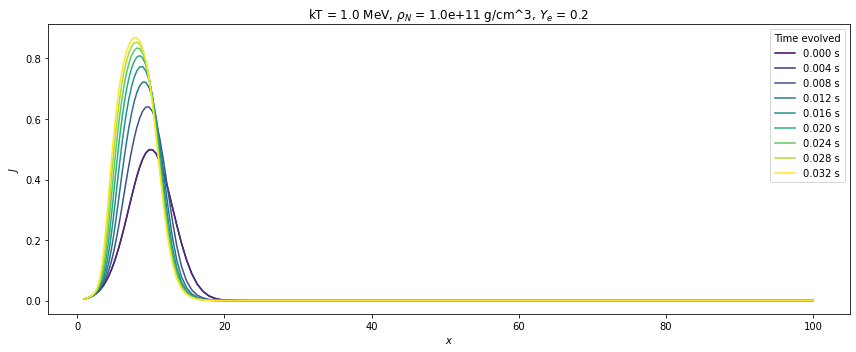

In [16]:
n_bins = 100
n_steps = 28000
dt = 1e-6 # s

kT = 1.0      # MeV
rho_N = 1e11  # g/cm^3
Y_e = 0.2

def init(eps):
    mean = 10
    sigma = 3
    return 0.5 * np.exp(-0.5 * (eps - mean)**2 / sigma**2)

es = np.geomspace(1, 100, num=n_bins)
Js = init(es)

Jlist = [Js]

for s in range(n_steps+1):
    Js, _, _, _ = step(kT, rho_N, Y_e, es, Js, dt)
    if (s % 4000) == 0:
        Jlist.append(Js)


plt.figure(figsize=(12,5), tight_layout=True)
colors = plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(Jlist)))

for i in range(len(Jlist)):
    plt.plot(es / kT, Jlist[i], color=colors[i], label=f'{i * 4000 * dt:.3f} s')

plt.legend(title='Time evolved')
plt.xlabel('$x$')
plt.ylabel('$J$')
plt.title(f'kT = {kT} MeV, $\\rho_N$ = {rho_N:.1e} g/cm^3, $Y_e$ = {Y_e}')
plt.show()

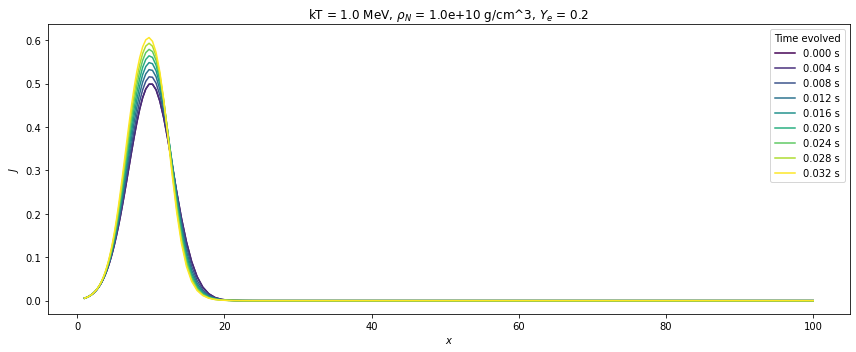